In [1]:
# read in the data here
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
df = pd.read_csv('../data/chrom_11_clean.csv', )
df

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1348,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
X = df.values

In [3]:
from sklearn.decomposition import PCA
n=X.shape[0]
p=X.shape[1]
ncausal_SNPs=30

## Normalize genotype data:
Xmean= np.mean(X, axis=0) #mean of each column, which corresponds to a SNP locus
Xstd= np.std(X,axis=0) #standard deviation of each column
X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations
# of each SNP locus. This is the final X. I use np.nan_to_num in case we get NaN values due to 
# 0 division, i.e. if everything in a column is 0, the mean and standard deviation will also be 0, 
# then we will get NaN values. np.nan_to_num turns NaNs into "0"s. This seemed like a good idea to me

<ipython-input-3-8dc6bbe370c0>:9: RuntimeWarning: invalid value encountered in true_divide
  X=np.nan_to_num((X-Xmean)/Xstd) # Standardized genotype matrix based on means and standard deviations


In [4]:
H2= 0.8 #80% of phenotypic variation is explained by genotype (heritability)
rho= 1 #100% of H^2 is explained by additive effects 

causal_SNPs_list = []
random_states_list = [1,2,3,4,5,6,7,8,9,10,11]
y_list = []

for i in range(0,11):
    random_state = random_states_list[i]
    causalSNPs=np.random.randint(low=0, high=10000, size=ncausal_SNPs)
    causal_SNPs_list.append(causalSNPs)
    Xadditive=X[:, causalSNPs] #the values for causal SNPs.
    betaAdd= np.repeat(1, ncausal_SNPs)#additive effect sizes initializes as "1"
    y_additive=np.dot(Xadditive, betaAdd) #initialize the value of the portion of phenotypic variation
    # caused by the additive effects as XB.
    betaAdd= betaAdd * np.sqrt(H2*rho/np.var(y_additive)) #Update additive effect sizes based on H^2, rho, and variation
    #in y_additive.
    y_additive=np.dot(Xadditive, betaAdd) #final value of y_additive, updated.
    y_additive=y_additive.reshape(n,1)
    y_noise = np.random.normal(size=n)
    y_noise = y_noise * np.sqrt((1 - H2-0.1) / np.var(y_noise))
    y_noise=y_noise.reshape(n,1)

    y = y_additive + y_noise #np.add(y_additive.reshape(n, 1), y_noise.reshape(n, 1), y_PC, y_epi.reshape(n, 1))
    y_list.append(y)
    # np.savetxt("timing/X_1000_1000.csv", X, delimiter=",")

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import statistics

In [23]:
def MLpipe_KFold_RMSE(X,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    causal_SNPs_list = []
    top_features_list = []
    
    for i in range(10):
        
        random_state = i * 112
        causalSNPs = np.random.randint(low=0, high=10000, size=ncausal_SNPs)
        causal_SNPs_list.append(causalSNPs)
        Xadditive = X[:, causalSNPs] #the values for causal SNPs.
        betaAdd = np.repeat(1, ncausal_SNPs)#additive effect sizes initializes as "1"
        y_additive = np.dot(Xadditive, betaAdd) #initialize the value of the portion of phenotypic variation
        # caused by the additive effects as XB.
        betaAdd = betaAdd * np.sqrt(H2*rho/np.var(y_additive)) #Update additive effect sizes based on H^2, rho, and variation
        #in y_additive.
        y_additive = np.dot(Xadditive, betaAdd) #final value of y_additive, updated.
        y_additive = y_additive.reshape(n,1)
        y_noise = np.random.normal(size=n)
        y_noise = y_noise * np.sqrt((1 - H2-0.1) / np.var(y_noise))
        y_noise = y_noise.reshape(n,1)
        y = y_additive + y_noise #np.add(y_additive.reshape(n, 1), y_noise.reshape(n, 1), y_PC, y_epi.reshape(n, 1))
        
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
        
        kf = KFold(n_splits=4,shuffle=True,random_state= random_state)  
        
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'neg_root_mean_squared_error',
                    cv=kf, return_train_score = True, verbose=True, n_jobs = -1)
        
        grid.fit(X_other, y_other.ravel())
        
        results = pd.DataFrame(grid.cv_results_)
        
        print('best model parameters:',grid.best_params_)
        best_models.append(grid)
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(mean_squared_error(y_test,y_test_pred)**(0.5))
        
        feature_importances = grid.best_estimator_.feature_importances_
        all_snps = np.array(list(range(0, 10000)))
        
        data={'feature_names':all_snps,'feature_importance':feature_importances}
        fi_df = pd.DataFrame(data)
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
        
        top_features = fi_df['feature_names']
        top_features = np.array(top_features)
        top_features_list.append(top_features)        
    
    print(np.mean(test_scores))
    print(np.std(test_scores))
    return best_models, test_scores, causal_SNPs_list, top_features_list


In [14]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[1, 3, 10, 30, 100,300],
             'max_features':[10, 100, 500, 1000, 5000, 10000]}

models, scores, causal_SNPs_list, top_features_list = MLpipe_KFold_RMSE(X,ML_algo,param_grid)
print(captured_SNPs_list)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  8.5min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  9.0min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 10.2min finished


best model parameters: {'max_depth': 30, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


best model parameters: {'max_depth': 300, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.7min finished


best model parameters: {'max_depth': 300, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.9min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.1min finished


best model parameters: {'max_depth': 100, 'max_features': 5000, 'n_estimators': 100}
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.3min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
0.7747048825404477
0.1567726102477407
[[3202, 7512, 7525, 454, 1319, 3563, 8779, 6846, 5715, 3412, 1332, 4820, 7159, 2456, 7518, 4799], [1827, 8900, 357, 134, 5829, 7400, 4265, 8554, 479, 915, 2196, 7477, 4694, 8025, 7386, 1661, 6431], [7072, 772, 5349, 7402, 875, 1868, 6285, 722, 7833, 3159, 4761, 4122, 8923], [4835, 1637, 6216, 1320, 4520, 9165, 6574, 1168, 6705, 7506, 1075, 5844, 6740, 4821, 18, 5112, 6295], [4387, 7876, 9894, 6247, 6344, 8649, 9962, 6539, 8844, 4176, 1169, 8145, 8400, 9206, 3736, 3679], [2592, 7359, 6245, 6537, 4394, 6891, 1644, 4525, 4622, 144, 7766, 4855, 728, 410, 8092, 1501, 9695], [8289, 1220, 1962, 8206, 6353, 6706, 3345, 116, 7445, 1010, 1437, 3710], [2144, 7203, 388, 3369, 398, 9742, 974, 1909, 7061, 5176, 4667, 3484, 893], [1383, 5834, 7947, 3404, 2861, 2222, 2735, 2762, 9263, 589, 3539, 9420, 6453, 6963, 407], [9537, 4738, 3907, 7397, 2791, 940, 8206, 463, 3956, 2742, 93

In [17]:
percentage_captured = []
for i in range(len(captured_SNPs_list)):
    captured_percent = len(captured_SNPs_list[i])/ncausal_SNPs
    percentage_captured.append(captured_percent)
np.mean(percentage_captured)
    

0.49393939393939396

Run again on different hyperparameter grid to further fine-tune. 

In [24]:
ML_algo = RandomForestRegressor()
param_grid = {'n_estimators':[100],
             'max_depth':[30, 100, 300],
             'max_features':[2000, 4000, 6000, 8000, 10000]}

models, scores, causal_SNPs_list, top_features_list = MLpipe_KFold_RMSE(X,ML_algo,param_grid)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.3min finished


best model parameters: {'max_depth': 100, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.6min finished


best model parameters: {'max_depth': 300, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.8min finished


best model parameters: {'max_depth': 30, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.7min finished


best model parameters: {'max_depth': 30, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.2min finished


best model parameters: {'max_depth': 30, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.0min finished


best model parameters: {'max_depth': 30, 'max_features': 6000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.2min finished


best model parameters: {'max_depth': 300, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.8min finished


best model parameters: {'max_depth': 30, 'max_features': 8000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.3min finished


best model parameters: {'max_depth': 100, 'max_features': 10000, 'n_estimators': 100}
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.8min finished


best model parameters: {'max_depth': 100, 'max_features': 6000, 'n_estimators': 100}
0.7186834548884311
0.14596324533357619


In [43]:
captured_top_30 = []
captured_top_100 = []
captured_top_1000 = []
captured_top_30_p = []
captured_top_100_p = []
captured_top_1000_p = []

for i in range(len(top_features_list)):
    top_features = top_features_list[i]
    causal_SNPs = causal_SNPs_list[i]
    top_30 = top_features_list[i][0:30]
    top_100 = top_features_list[i][0:100]
    top_1000 = top_features_list[i][0:1000]
    captured_SNPs_30 = list(set(top_30).intersection(causal_SNPs))
    captured_SNPs_100 = list(set(top_100).intersection(causal_SNPs))
    captured_SNPs_1000 = list(set(top_1000).intersection(causal_SNPs))
    captured_top_30.append(captured_SNPs_30)
    captured_top_100.append(captured_SNPs_100)
    captured_top_1000.append(captured_SNPs_1000)
    captured_top_30_p.append(len(captured_SNPs_30)/ncausal_SNPs)
    captured_top_100_p.append(len(captured_SNPs_100)/ncausal_SNPs)
    captured_top_1000_p.append(len(captured_SNPs_1000)/ncausal_SNPs)

In [44]:
print(np.mean(captured_top_30_p))
print(np.std(captured_top_30_p))
print(np.mean(captured_top_100_p))
print(np.std(captured_top_100_p))
print(np.mean(captured_top_1000_p))
print(np.std(captured_top_1000_p))

0.49333333333333335
0.08537498983243798
0.6900000000000001
0.08306623862918078
0.7233333333333334
0.07000000000000005


In [47]:
prop_30 = np.mean(captured_top_30_p)
prop_100 = np.mean(captured_top_100_p)
prop_1000 = np.mean(captured_top_1000_p)
std_30 = np.std(captured_top_30_p)
std_100 = np.std(captured_top_100_p)
std_1000 = np.std(captured_top_1000_p)

In [53]:
props = [prop_30, prop_100, prop_1000]
stds = [std_30, std_100, std_1000]

In [48]:
range_top_30_p = [prop_30 - 2*std_30, prop_30+ 2*std_30]
range_top_100_p = [prop_100 - 2*std_100, prop_100+ 2*std_100]
range_top_1000_p = [prop_1000 - 2*std_1000, prop_1000+ 2*std_1000]

In [50]:
print(range_top_30_p)
print(range_top_100_p)
print(range_top_1000_p)

[0.32258335366845736, 0.6640833129982093]
[0.5238675227416385, 0.8561324772583616]
[0.5833333333333333, 0.8633333333333335]


In [51]:
import matplotlib
from matplotlib import pylab as plt

<ErrorbarContainer object of 3 artists>

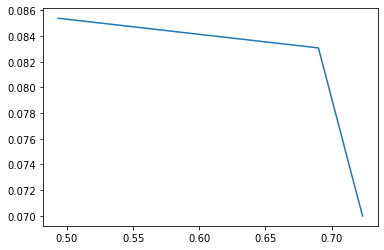

In [55]:
matplotlib.pyplot.errorbar(props, stds)

In [ ]:
captured_SNPs_1 = list(set(top_features).intersection(causalSNPs))
captured_SNPs_list.append(captured_SNPs)

In [75]:
X_trains = []
X_tests = []
y_trains = []
y_tests = []
for i in range(0,3):
    X_train, X_test, y_train, y_test = train_test_split(X,y_list[i],test_size = 0.2, random_state=112)
    #y_train = y_train.reshape(-1,1)
    #y_test = y_test.reshape(-1,1)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [76]:
clf = RandomForestRegressor(n_estimators=100,max_depth=30,random_state=112)
clf.fit(X_trains[0],y_trains[0])

<ipython-input-76-12ac1829bf51>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_trains[0],y_trains[0])


RandomForestRegressor(max_depth=30, random_state=112)

In [78]:
y_preds_1 = clf.predict(X_tests[0])

In [79]:
y_preds_1

array([-0.35051613, -0.1938484 , -0.37275632,  1.39358634, -0.08542554,
       -0.15766576, -0.71454069, -0.12424734, -0.23411722, -0.4968749 ,
        0.66385013,  0.36860667,  0.26644805, -0.69086835,  0.2800884 ,
       -0.81723968,  0.38314932,  0.62413684,  0.17702072, -0.06957111,
        0.4685548 ,  0.80298139, -0.6820792 , -0.42423175, -0.29771865,
        0.03992219,  0.33756828, -0.34691656, -0.73281818,  0.42245365,
       -0.51856676, -0.41291133, -0.37585263,  1.48471915,  1.13098465,
        0.56142139,  1.37927007, -0.30810007, -0.02974392, -0.29330936,
       -0.07069375, -0.36175083, -0.37387502, -0.28568778, -0.33708043,
       -0.68138409,  0.41371924, -0.32529278,  0.03931023, -0.17113523,
       -0.03728017, -0.0772031 , -0.13019436, -0.13689651, -0.61352603,
        0.83066629, -0.13107476, -0.32493661, -0.09095916, -0.06391949,
       -0.02391122, -0.1413972 ,  0.91414202, -0.65630648, -0.23041476,
       -0.05801104, -0.1740946 , -0.57145216,  0.27019669,  0.67

In [82]:
feature_importances = clf.feature_importances_

In [87]:
len(feature_importances)

10000

In [94]:
all_snps = np.array(list(range(0, 10000)))

In [95]:
data={'feature_names':all_snps,'feature_importance':feature_importances}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df

,feature_names,feature_importance
3112,3112,0.200391
8984,8984,0.027190
8773,8773,0.027008
8988,8988,0.022929
6021,6021,0.019628
...,...,...
5860,5860,0.000000
2538,2538,0.000000
2540,2540,0.000000
5857,5857,0.000000


In [103]:
causal_SNPs_1 = np.sort(causal_SNPs_list[0])
causal_SNPs_1

array([ 250, 1557, 1680, 1777, 2160, 2191, 3013, 3498, 3609, 4236, 4585,
       5589, 5675, 5842, 6021, 6422, 6486, 6831, 7555, 7582, 8179, 8286,
       8773, 8848, 8984, 8988, 9398, 9741, 9862, 9879])

In [108]:
top_features1 = fi_df['feature_names']
top_features1 = np.array(top_features1[0:30])
top_features1 = np.sort(top_features1)
top_features1

array([ 231,  584,  669,  911, 1187, 1262, 1507, 1802, 2191, 2700, 3013,
       3112, 3216, 3609, 4585, 5675, 5753, 5922, 6021, 6422, 6532, 6831,
       7555, 8526, 8773, 8984, 8988, 9802, 9862, 9879])

In [109]:
list(set(top_features1).intersection(causal_SNPs_1))

[7555,
 3013,
 6021,
 8773,
 9862,
 4585,
 5675,
 2191,
 6831,
 6422,
 9879,
 8984,
 3609,
 8988]